### Análisis de Datos del conjunto de datos de préstamos de Lending Club

Antes de abordar la creación del notebook centrado en un enfoque de deep learning sobre el conjunto de datos de Lending Club, es imperativo adquirir una comprensión detallada del mismo. Con este propósito, he decidido seguir un notebook que se enfoca en una sección de Análisis de Datos.

### Importante !!!

Este código se basa en el notebook de Kaggle titulado "Lending Club Loan Defaulters Prediction" creado por Fares Sayah. 

Puedes encontrar el notebook original en el siguiente enlace:
https://www.kaggle.com/code/chr7stos/lending-club-loan-defaulters-prediction/notebook

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.metrics import roc_auc_score, roc_curve, auc

import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import AUC

plt.style.use("fivethirtyeight")
sns.set_style('whitegrid')
%matplotlib inline

pd.set_option('display.float', '{:.2f}'.format)
pd.set_option('display.max_columns', 50)
pd.set_option('display.max_rows', 50)

In [2]:
data = pd.read_csv("lending_club_loan_two.csv")

data.describe()

,loan_amnt,int_rate,installment,annual_inc,dti,open_acc,pub_rec,revol_bal,revol_util,total_acc,mort_acc,pub_rec_bankruptcies
count,396030.00,396030.00,396030.00,396030.00,396030.00,396030.00,396030.00,396030.00,395754.00,396030.00,358235.00,395495.00
mean,14113.89,13.64,431.85,74203.18,17.38,11.31,0.18,15844.54,53.79,25.41,1.81,0.12
std,8357.44,4.47,250.73,61637.62,18.02,5.14,0.53,20591.84,24.45,11.89,2.15,0.36
min,500.00,5.32,16.08,0.00,0.00,0.00,0.00,0.00,0.00,2.00,0.00,0.00
25%,8000.00,10.49,250.33,45000.00,11.28,8.00,0.00,6025.00,35.80,17.00,0.00,0.00
50%,12000.00,13.33,375.43,64000.00,16.91,10.00,0.00,11181.00,54.80,24.00,1.00,0.00
75%,20000.00,16.49,567.30,90000.00,22.98,14.00,0.00,19620.00,72.90,32.00,3.00,0.00
max,40000.00,30.99,1533.81,8706582.00,9999.00,90.00,86.00,1743266.00,892.30,151.00,34.00,8.00


### Obtener una comprensión de qué variables son importantes, revisar estadísticas resumidas y visualizar los datos.

In [3]:
# Muestra el tipo de datos de cada columna y la cantidad de valores no nulos
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 396030 entries, 0 to 396029
Data columns (total 27 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   loan_amnt             396030 non-null  float64
 1   term                  396030 non-null  object 
 2   int_rate              396030 non-null  float64
 3   installment           396030 non-null  float64
 4   grade                 396030 non-null  object 
 5   sub_grade             396030 non-null  object 
 6   emp_title             373103 non-null  object 
 7   emp_length            377729 non-null  object 
 8   home_ownership        396030 non-null  object 
 9   annual_inc            396030 non-null  float64
 10  verification_status   396030 non-null  object 
 11  issue_d               396030 non-null  object 
 12  loan_status           396030 non-null  object 
 13  purpose               396030 non-null  object 
 14  title                 394274 non-null  object 
 15  

<Axes: xlabel='count', ylabel='loan_status'>

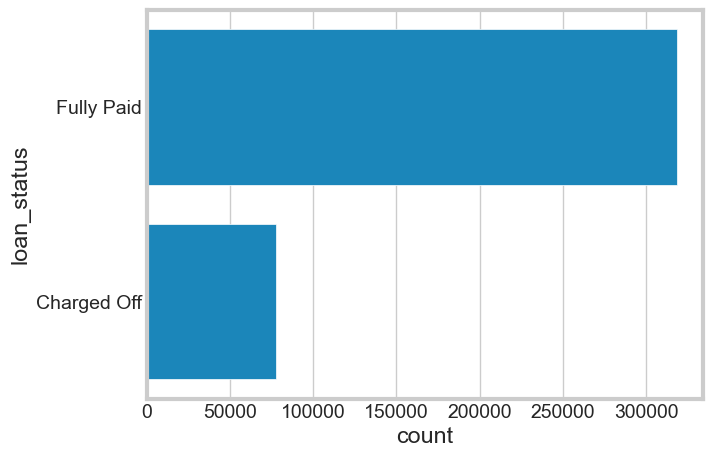

In [4]:
# El gráfico de conteo mostrará la cantidad de cada tipo de 'loan_status' en el DataFrame.
# Cada barra en el gráfico representa una categoría distinta de 'loan_status',
# y la altura de la barra representa el número de observaciones que pertenecen a esa categoría.
sns.countplot(data.loan_status)

<Axes: >

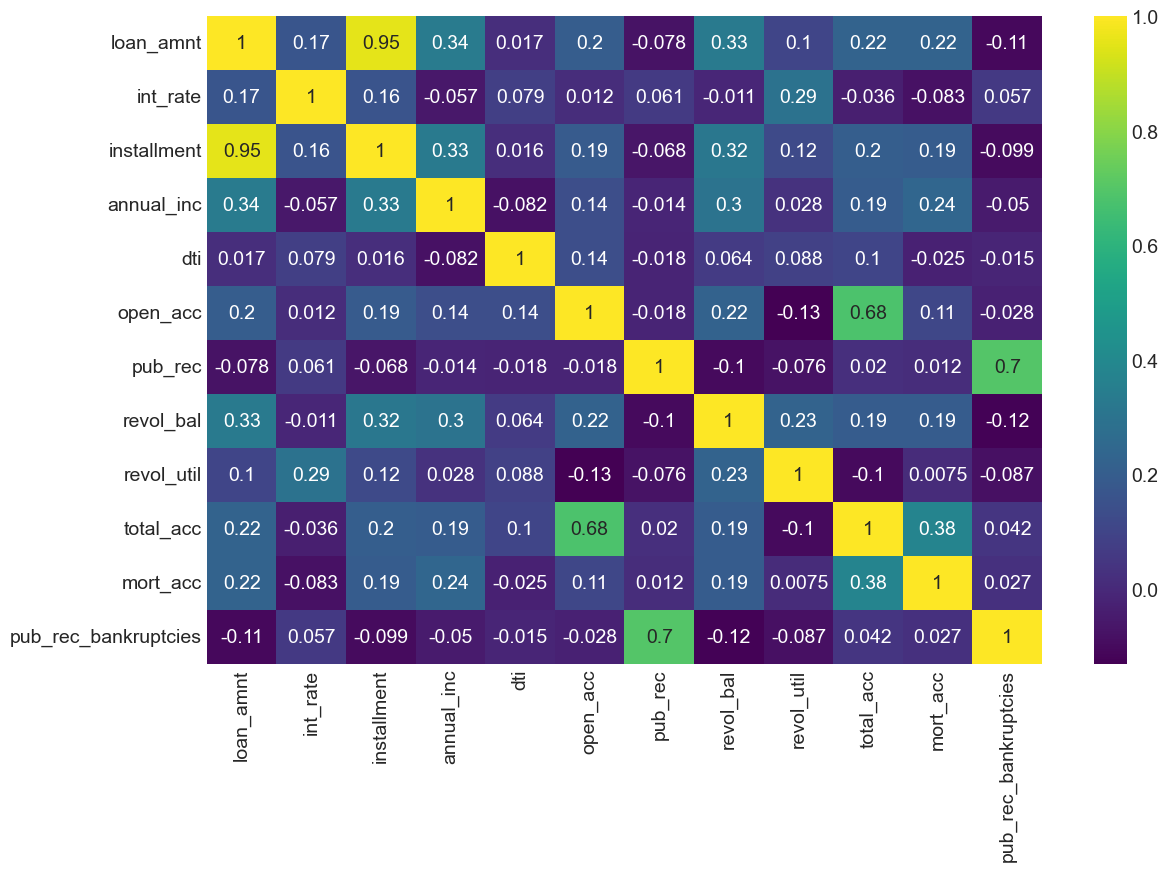

In [5]:
# Primero, se establece el tamaño de la figura a 12x8 con plt.figure(figsize=(12, 8)).
# Luego, se utiliza sns.heatmap() para crear el mapa de calor. 
# 'data.corr()' calcula la correlación entre todas las columnas numéricas en 'data'.
# 'annot=True' significa que los valores de correlación se mostrarán en el mapa de calor.
# 'cmap='viridis'' establece el esquema de colores del mapa de calor a 'viridis'.

data_numeric = data.select_dtypes(include=[np.number])

plt.figure(figsize=(12, 8))
sns.heatmap(data_numeric.corr(), annot=True, cmap='viridis')

Ojo !!!, Observar que hay una correlación casi perfecta entre la característica 'loan_amnt' y la característica 'installment, debemos que asegurar que es lo que esta pasando con esa correlación.

Text(0.5, 0, 'loan_amnt')

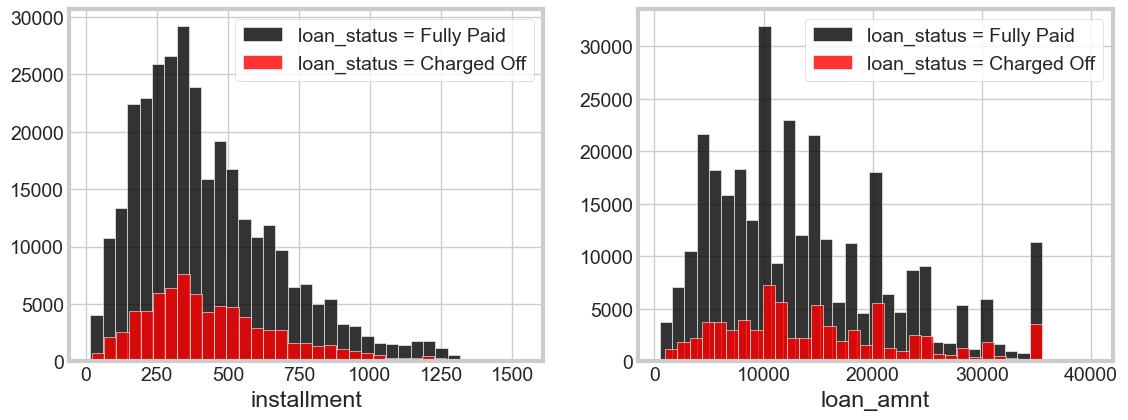

In [6]:
# El primer histograma (subplot 1) muestra la distribución de la columna 'installment' para los préstamos que están 'Fully Paid' y 'Charged Off'.
# Los datos se dividen en 35 bins (rangos de valores), y los histogramas se colorean en negro y rojo respectivamente.
# Se añade una leyenda para indicar qué c
# El segundo histograma (subplot 2) hace lo mismo pero para la columna 'loan_amnt'.
plt.figure(figsize=(12, 20))

plt.subplot(4, 2, 1)
data[data["loan_status"] == "Fully Paid"]["installment"].hist(bins=35, color='black', label='loan_status = Fully Paid', alpha=0.8)
data[data["loan_status"] == "Charged Off"]["installment"].hist(bins=35, color='red', label='loan_status = Charged Off', alpha=0.8)
plt.legend()
plt.xlabel("installment")

plt.subplot(4, 2, 2)
data[data["loan_status"] == "Fully Paid"]["loan_amnt"].hist(bins=35, color='black', label='loan_status = Fully Paid', alpha=0.8)
data[data["loan_status"] == "Charged Off"]["loan_amnt"].hist(bins=35, color='red', label='loan_status = Charged Off', alpha=0.8)
plt.legend()
plt.xlabel("loan_amnt")

In [7]:
data.groupby(by='loan_status')['loan_amnt'].describe()

,count,mean,std,min,25%,50%,75%,max
loan_status,,,,,,,,
Charged Off,77673.00,15126.30,8505.09,1000.00,8525.00,14000.00,20000.00,40000.00
Fully Paid,318357.00,13866.88,8302.32,500.00,7500.00,12000.00,19225.00,40000.00


Veamos las columnas de Grado y Subgrado que LendingClub asigna a los préstamos:

/var/folders/xd/h04l7v913hgggttmyfmtmw7r0000gn/T/ipykernel_4897/4209085665.py:14: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  g.set_xticklabels(g.get_xticklabels(), rotation=90);


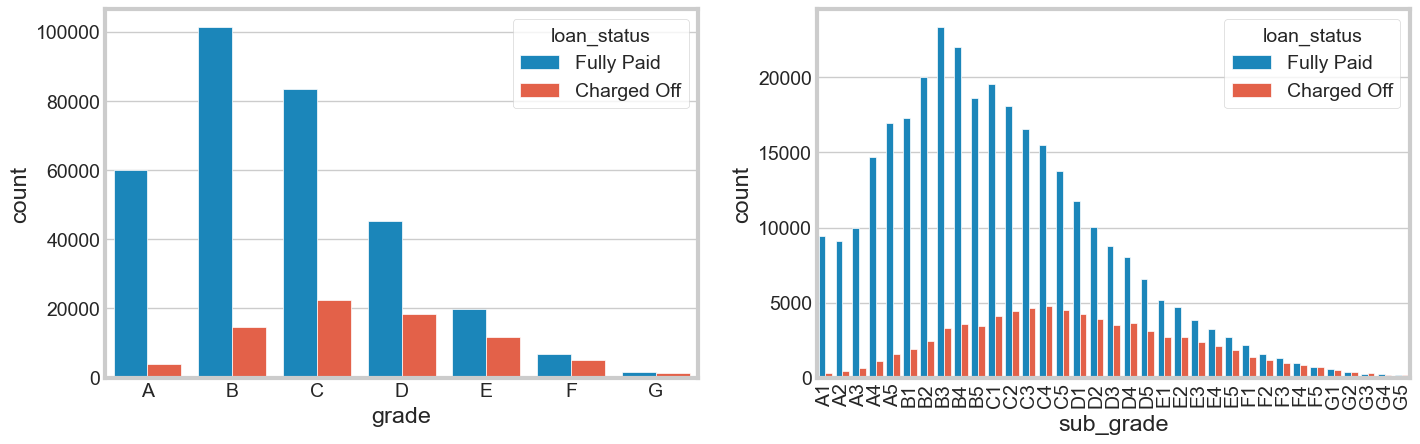

In [8]:
# El primer gráfico (subplot 1) muestra el conteo de cada 'grade' en el DataFrame, dividido por 'loan_status'.

# El segundo gráfico (subplot 2) hace lo mismo pero para la columna 'sub_grade'.

plt.figure(figsize=(15, 10))

plt.subplot(2, 2, 1)
grade = sorted(data.grade.unique().tolist())
sns.countplot(x='grade', data=data, hue='loan_status', order=grade)

plt.subplot(2, 2, 2)
sub_grade = sorted(data.sub_grade.unique().tolist())
g = sns.countplot(x='sub_grade', data=data, hue='loan_status', order=sub_grade)
g.set_xticklabels(g.get_xticklabels(), rotation=90);

<Axes: xlabel='sub_grade', ylabel='count'>

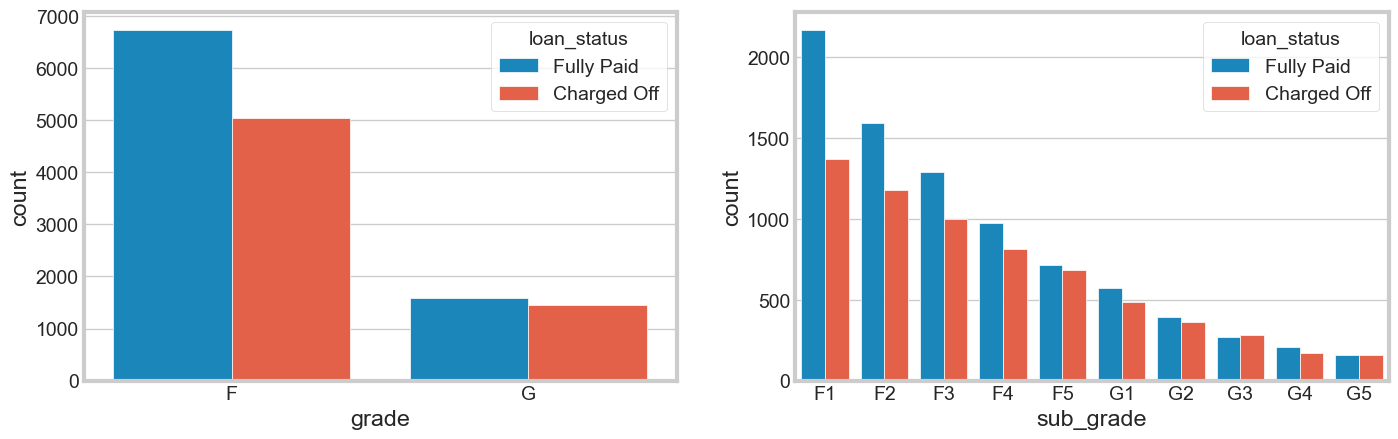

In [9]:
# El primer gráfico (subplot 1) muestra el conteo de cada 'grade' en el DataFrame filtrado 'df', dividido por 'loan_status'.
# Los grados se ordenan antes de trazar el gráfico. Se utiliza un gráfico de conteo de Seaborn (sns.countplot) para esto.

# El segundo gráfico (subplot 2) hace lo mismo pero para la columna 'sub_grade'.
df = data[(data.grade == 'F') | (data.grade == 'G')]

plt.figure(figsize=(15, 10))

plt.subplot(2, 2, 1)
grade = sorted(df.grade.unique().tolist())
sns.countplot(x='grade', data=df, hue='loan_status', order=grade)

plt.subplot(2, 2, 2)
sub_grade = sorted(df.sub_grade.unique().tolist())
sns.countplot(x='sub_grade', data=df, hue='loan_status', order=sub_grade)

In [10]:
data.home_ownership.value_counts()

home_ownership
MORTGAGE    198348
RENT        159790
OWN          37746
OTHER          112
NONE            31
ANY              3
Name: count, dtype: int64

In [11]:
data.loc[(data.home_ownership == 'ANY') | (data.home_ownership == 'NONE'), 'home_ownership'] = 'OTHER'  
data.home_ownership.value_counts()

home_ownership
MORTGAGE    198348
RENT        159790
OWN          37746
OTHER          146
Name: count, dtype: int64

/var/folders/xd/h04l7v913hgggttmyfmtmw7r0000gn/T/ipykernel_4897/467544093.py:22: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  g.set_xticklabels(g.get_xticklabels(), rotation=90);


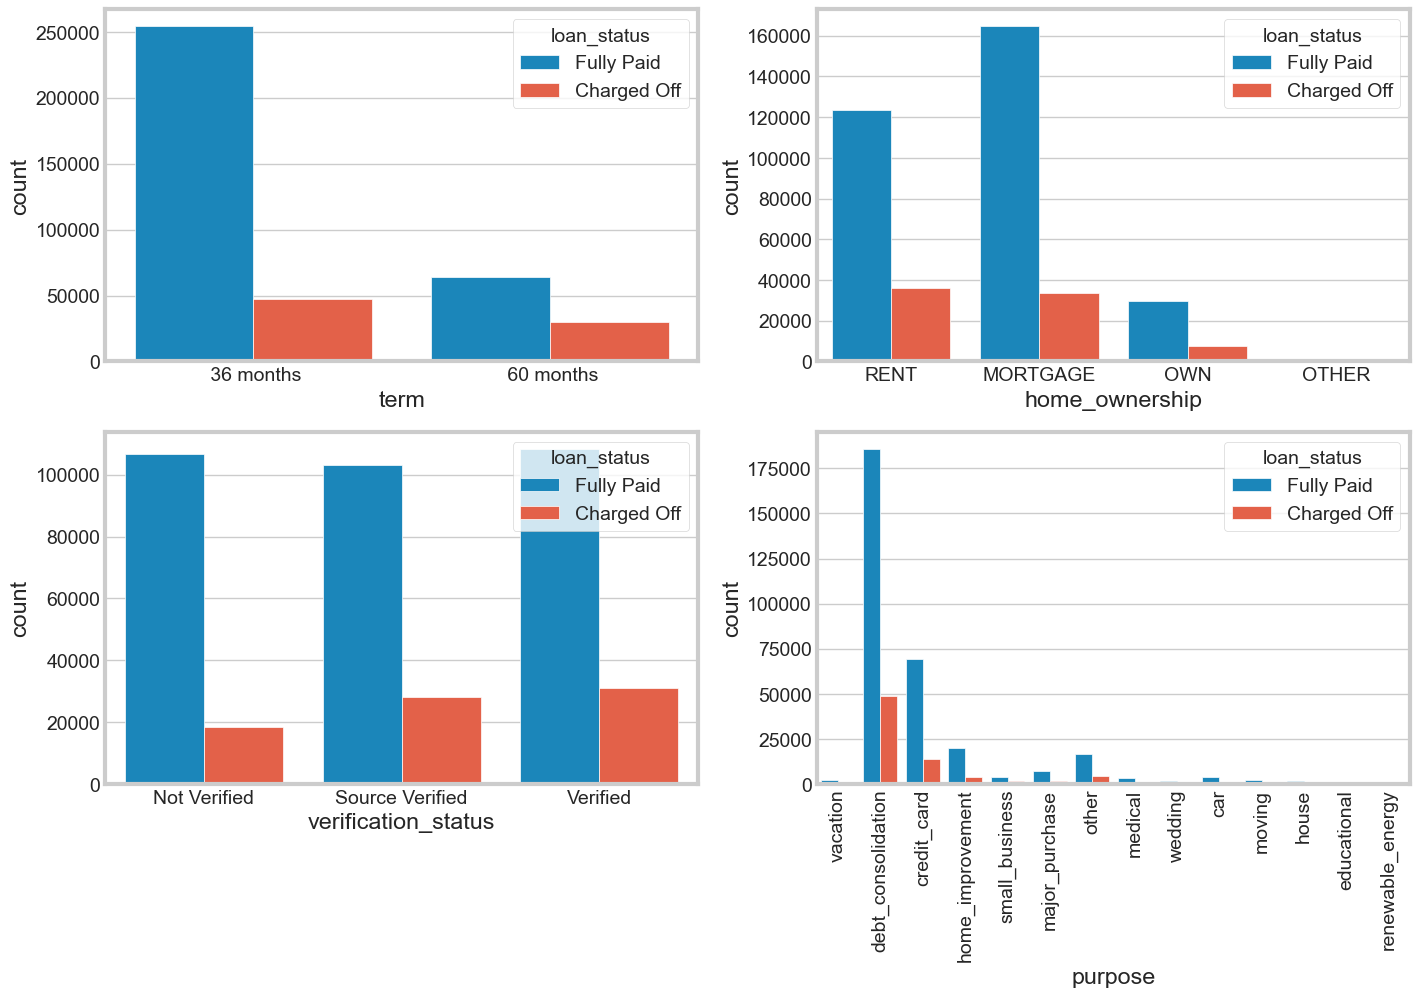

In [12]:
# El primer gráfico (subplot 1) muestra el conteo de cada valor único en la columna 'term' en el DataFrame, dividido por 'loan_status'.

# El segundo gráfico (subplot 2) hace lo mismo pero para la columna 'home_ownership'.

# El tercer gráfico (subplot 3) hace lo mismo pero para la columna 'verification_status'.

# El cuarto gráfico (subplot 4) hace lo mismo pero para la columna 'purpose'.

plt.figure(figsize=(15, 20))

plt.subplot(4, 2, 1)
sns.countplot(x='term', data=data, hue='loan_status')

plt.subplot(4, 2, 2)
sns.countplot(x='home_ownership', data=data, hue='loan_status')

plt.subplot(4, 2, 3)
sns.countplot(x='verification_status', data=data, hue='loan_status')

plt.subplot(4, 2, 4)
g = sns.countplot(x='purpose', data=data, hue='loan_status')
g.set_xticklabels(g.get_xticklabels(), rotation=90);

66     47000.00
87    187321.00
96     43000.00
97     56000.00
123    72500.00
Name: annual_inc, dtype: float64

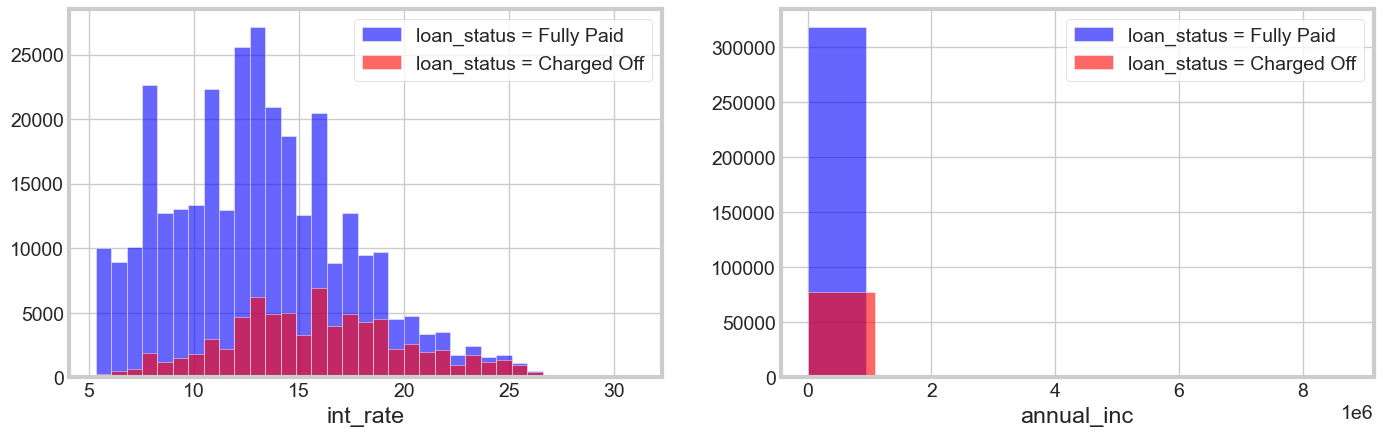

In [13]:
# El primer histograma (subplot 1) muestra la distribución de la columna 'int_rate' para los préstamos que están 'Fully Paid' y 'Charged Off'.
# Los datos se dividen en 35 bins (rangos de valores), y los histogramas se colorean en azul y rojo respectivamente.
# Se añade una leyenda para indicar qué color corresponde a cada 'loan_status'.
# Finalmente, se etiqueta el eje x con el nombre de la columna ('int_rate').

# El segundo histograma (subplot 2) hace lo mismo pero para la columna 'annual_inc', y se dividen los datos en 8 bins.

# Finalmente, se muestra las primeras 5 filas de la columna 'annual_inc' del DataFrame 'df'.
plt.figure(figsize=(15, 10))

plt.subplot(2, 2, 1)
data[data["loan_status"] == "Fully Paid"]["int_rate"].hist(bins=35, color='blue', label='loan_status = Fully Paid', alpha=0.6)
data[data["loan_status"] == "Charged Off"]["int_rate"].hist(bins=35, color='red', label='loan_status = Charged Off', alpha=0.6)
plt.legend()
plt.xlabel("int_rate")

plt.subplot(2, 2, 2)
data[data["loan_status"] == "Fully Paid"]["annual_inc"].hist(bins=8, color='blue', label='loan_status = Fully Paid', alpha=0.6)
data[data["loan_status"] == "Charged Off"]["annual_inc"].hist(bins=8, color='red', label='loan_status = Charged Off', alpha=0.6)
plt.legend()
plt.xlabel("annual_inc")

df["annual_inc"].head()

(75, 27)

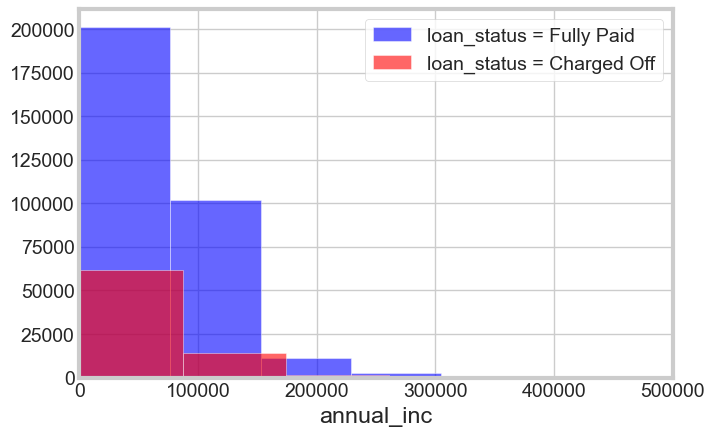

In [14]:
# Los datos se dividen en 100 bins (rangos de valores), y los histogramas se colorean en azul y rojo respectivamente.
# Se añade una leyenda para indicar qué color corresponde a cada 'loan_status'.
# Finalmente, se etiqueta el eje x con el nombre de la columna ('annual_inc') y se limita el rango del eje x a [0, 500000].
plt.figure(figsize=(15, 10))

plt.subplot(2, 2, 2)
data[data["loan_status"] == "Fully Paid"]["annual_inc"].hist(bins=100, color='blue', label='loan_status = Fully Paid', alpha=0.6)
data[data["loan_status"] == "Charged Off"]["annual_inc"].hist(bins=100, color='red', label='loan_status = Charged Off', alpha=0.6)
plt.legend()
plt.xlabel("annual_inc")
plt.xlim([0, 500000])

data[data.annual_inc >= 1000000].shape

In [15]:
data[data.annual_inc >= 1000000].shape

(75, 27)

In [16]:
data.emp_title.isna().sum()
data['emp_title'] = data.emp_title.str.lower()

In [17]:
# Cada función comprueba si la cadena de texto contiene una palabra específica ('manager', 'president', 'nurse', 'driver', 'assistant', 'engineer').
# Si la cadena contiene la palabra, la función devuelve esa palabra. Si no, devuelve la cadena original.
# Luego, estas funciones se aplican a la columna 'emp_title' del DataFrame 'data' una por una.
# Como resultado, si el título del empleo contiene alguna de las palabras especificadas, se reemplaza por esa palabra.

def manager(string):
    if type(string) is str:
        return 'manager' if 'manager' in string else string

def president(string):
    if type(string) is str:
        return 'president' if 'president' in string else string
    
def nurse(string):
    if type(string) is str:
        return 'nurse' if 'nurse' in string else string
    
def driver(string):
    if type(string) is str:
        return 'driver' if 'driver' in string else string
    
def assistant(string):
    if type(string) is str:
        return 'assistant' if 'assistant' in string else string

def engineer(string):
    if type(string) is str:
        return 'engineer' if 'engineer' in string else string    

functions = [manager, president, nurse, driver, assistant, engineer]
for func in functions:
    data['emp_title'] = data.emp_title.apply(func)

In [18]:
data.emp_title.value_counts()[:30]

emp_title
manager              39831
engineer              8603
assistant             7548
driver                5743
teacher               5430
nurse                 5146
president             3276
supervisor            2591
sales                 2382
owner                 2201
rn                    2074
director              1192
police officer        1041
accountant             845
technician             839
mechanic               753
attorney               744
analyst                703
us army                671
paralegal              586
customer service       563
server                 538
electrician            527
foreman                506
operator               490
controller             470
consultant             463
bank of america        459
clerk                  452
account executive      447
Name: count, dtype: int64

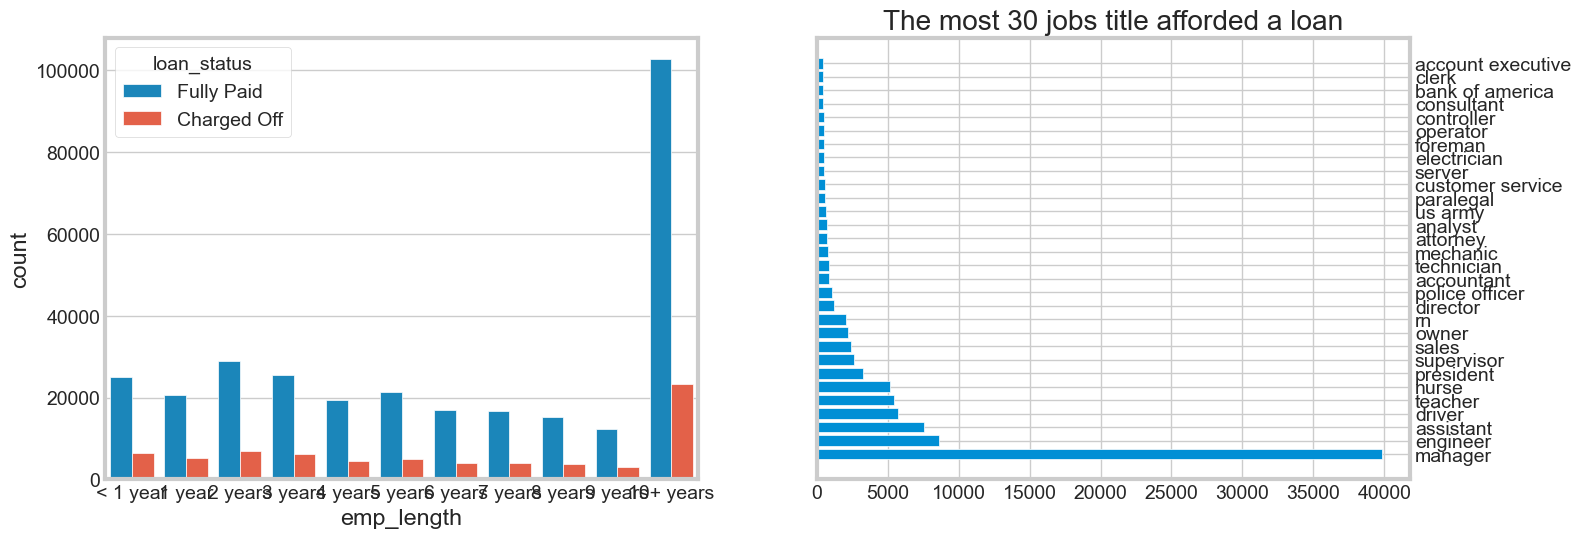

In [19]:
# El primer gráfico (subplot 1) es un gráfico de conteo de Seaborn que muestra la cantidad de cada valor único en la columna 'emp_length' en el DataFrame 'data', dividido por 'loan_status'.

# El segundo gráfico (subplot 2) es un gráfico de barras horizontales que muestra los 30 títulos de trabajo más comunes que obtuvieron un préstamo.

plt.figure(figsize=(15, 12))

plt.subplot(2, 2, 1)
order = ['< 1 year', '1 year', '2 years', '3 years', '4 years', '5 years', 
          '6 years', '7 years', '8 years', '9 years', '10+ years',]
sns.countplot(x='emp_length', data=data, hue='loan_status', order=order)

plt.subplot(2, 2, 2)
plt.barh(data.emp_title.value_counts()[:30].index, data.emp_title.value_counts()[:30])
plt.title("The most 30 jobs title afforded a loan")
plt.gca().yaxis.tick_right()

<Axes: xlabel='earliest_cr_line'>

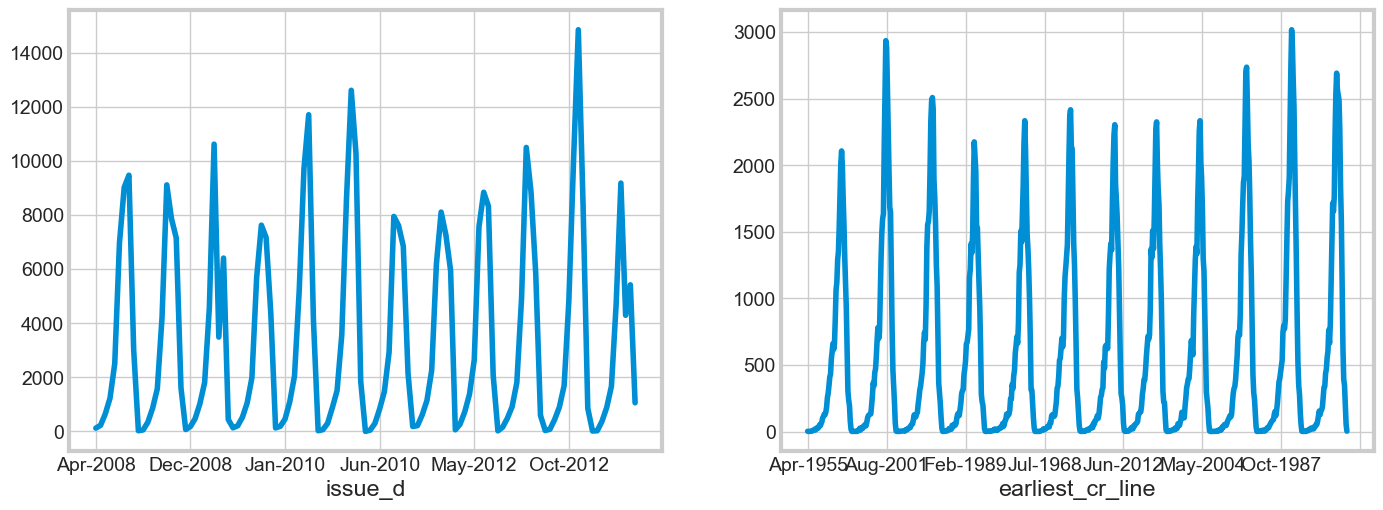

In [20]:
# El primer gráfico (subplot 1) es un gráfico de líneas que muestra la cantidad de préstamos emitidos en cada fecha.
# Las fechas se obtienen de la columna 'issue_d' del DataFrame

# El segundo gráfico (subplot 2) es un gráfico de líneas que muestra la cantidad de líneas de crédito abiertas en cada fecha.
# Las fechas se obtienen de la columna 'earliest_cr_line' del DataFrame 'data'.

plt.figure(figsize=(15, 12))

plt.subplot(2, 2, 1)
data.issue_d.value_counts().sort_index().plot()

plt.subplot(2, 2, 2)
data.earliest_cr_line.value_counts().sort_index().plot()

In [21]:
data.title.isna().sum
data['title'] = data.title.str.lower()

In [22]:
data.title.value_counts()[:30]

title
debt consolidation           168108
credit card refinancing       51781
home improvement              17117
other                         12993
consolidation                  5583
major purchase                 4998
debt consolidation loan        3513
business                       3017
medical expenses               2820
credit card consolidation      2638
personal loan                  2460
car financing                  2160
credit card payoff             1904
consolidation loan             1887
vacation                       1866
credit card refinance          1832
moving and relocation          1693
consolidate                    1528
personal                       1465
home buying                    1196
loan                           1150
payoff                         1035
credit cards                   1030
freedom                         934
debt                            933
my loan                         897
credit card loan                879
credit card           

In [23]:
data.dti.value_counts()

dti
0.00     313
14.40    310
19.20    302
16.80    301
18.00    300
        ... 
59.18      1
48.37      1
45.71      1
42.38      1
55.53      1
Name: count, Length: 4262, dtype: int64

In [24]:
data[data.revol_bal < 10000].shape

(177624, 27)

In [25]:
data[data.revol_util > 200]

,loan_amnt,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,purpose,title,dti,earliest_cr_line,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,application_type,mort_acc,pub_rec_bankruptcies,address
137211,3500.00,36 months,12.49,117.08,B,B4,budget analyst,10+ years,RENT,45000.00,Verified,Apr-2014,Fully Paid,debt_consolidation,debt consolidation,14.67,Oct-1998,2.00,0.00,2677.00,892.30,9.00,f,INDIVIDUAL,0.00,0.00,"12506 Connie Burg\r\nVelasquezfort, TN 00813"


Text(0.5, 0, 'total_acc')

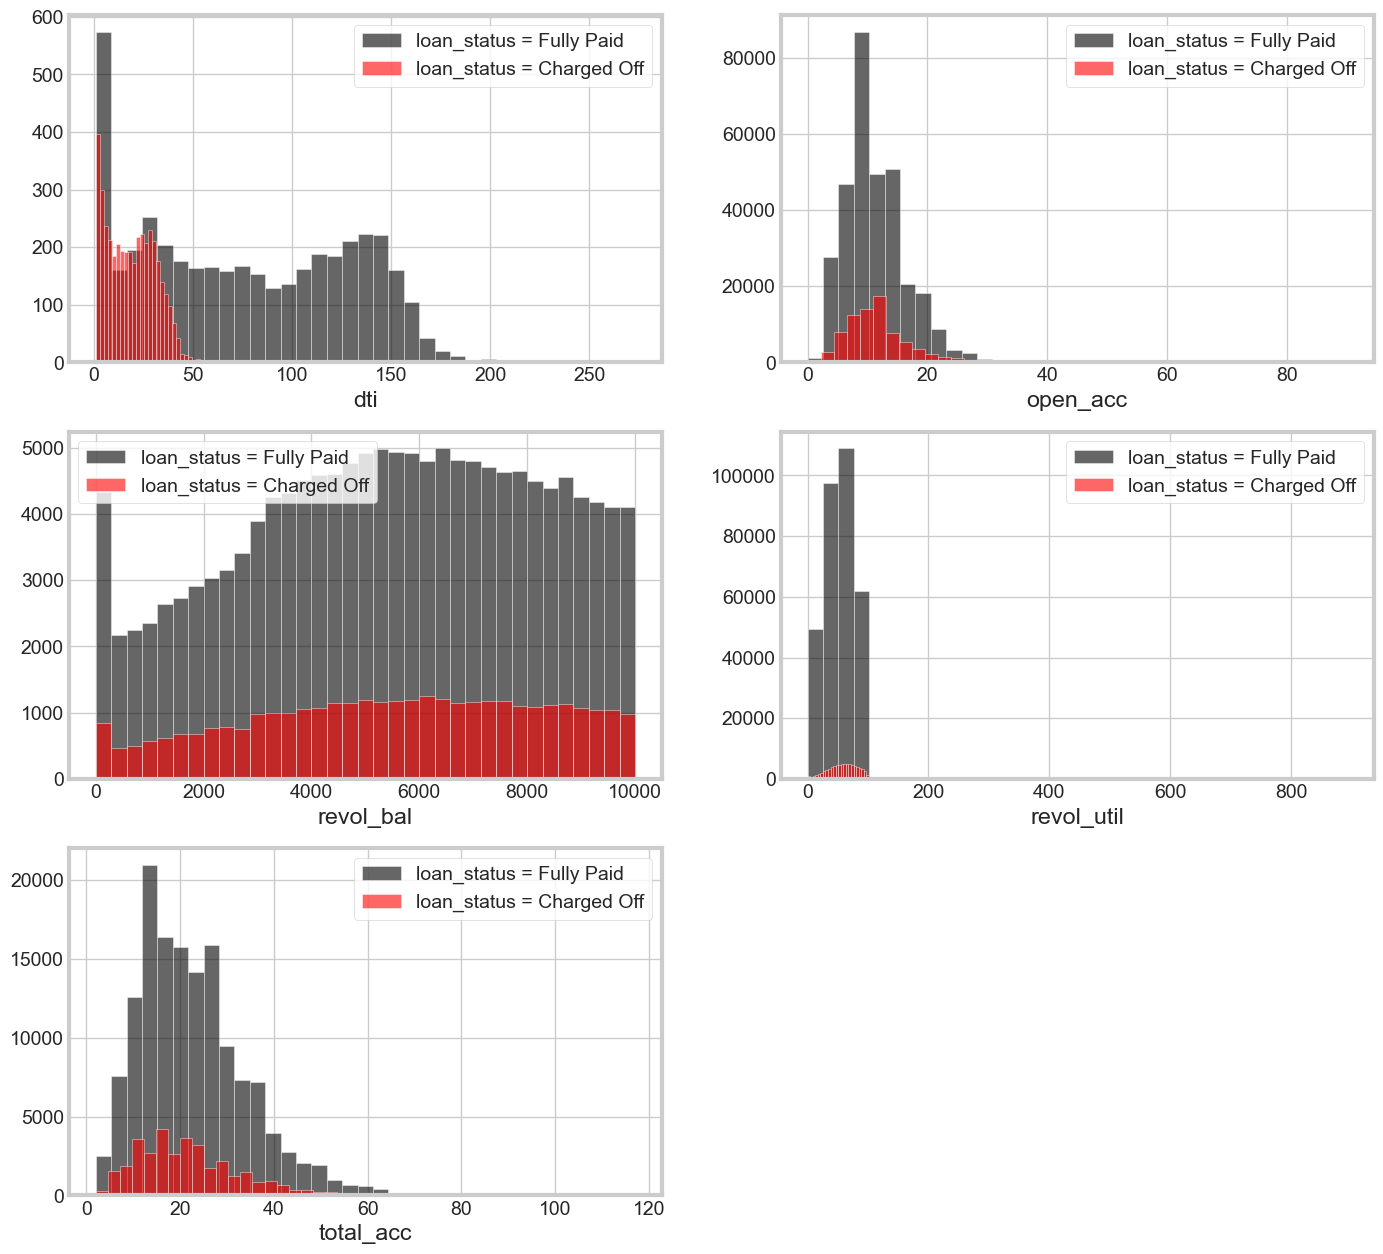

In [26]:
# Cada histograma representa la distribución de una variable específica ('dti', 'open_acc', 'revol_bal', 'revol_util', 'total_acc') para los préstamos que están 'Fully Paid' y 'Charged Off'.

plt.figure(figsize=(15, 30))

plt.subplot(6, 2, 1)
data[data["loan_status"] == "Fully Paid"]["dti"].value_counts().hist(bins=35, color='black', 
                                                                     label='loan_status = Fully Paid', alpha=0.6)
data[data["loan_status"] == "Charged Off"]["dti"].value_counts().hist(bins=35, color='red', 
                                                                      label='loan_status = Charged Off', alpha=0.6)
plt.legend()
plt.xlabel("dti")

plt.subplot(6, 2, 2)
data[data["loan_status"] == "Fully Paid"]["open_acc"].hist(bins=35, color='black', label='loan_status = Fully Paid', alpha=0.6)
data[data["loan_status"] == "Charged Off"]["open_acc"].hist(bins=35, color='red', label='loan_status = Charged Off', alpha=0.6)
plt.legend()
plt.xlabel("open_acc")

plt.subplot(6, 2, 3)
df = data[(data.revol_bal <= 10000)]
df[df["loan_status"] == "Fully Paid"]["revol_bal"].hist(bins=35, color='black', label='loan_status = Fully Paid', alpha=0.6)
df[df["loan_status"] == "Charged Off"]["revol_bal"].hist(bins=35, color='red', label='loan_status = Charged Off', alpha=0.6)
plt.legend()
plt.xlabel("revol_bal")

plt.subplot(6, 2, 4)
data[data["loan_status"] == "Fully Paid"]["revol_util"].hist(bins=35, color='black', label='loan_status = Fully Paid', alpha=0.6)
data[data["loan_status"] == "Charged Off"]["revol_util"].hist(bins=35, color='red', label='loan_status = Charged Off', alpha=0.6)
plt.legend()
plt.xlabel("revol_util")

plt.subplot(6, 2, 5)
df = data[(data.revol_bal <= 10000)]
df[df["loan_status"] == "Fully Paid"]["total_acc"].hist(bins=35, color='black', label='loan_status = Fully Paid', alpha=0.6)
df[df["loan_status"] == "Charged Off"]["total_acc"].hist(bins=35, color='red', label='loan_status = Charged Off', alpha=0.6)
plt.legend()
plt.xlabel("total_acc")

Parece que cuanto menor es el índice deuda/ingresos (DTI), es más probable que el préstamo no se pague.

Solo 217 prestatarios tienen más de 40 líneas de crédito abiertas.

Solo 266 prestatarios tienen más de 80 líneas de crédito en el archivo de crédito del prestatario.

In [27]:
data.pub_rec.value_counts()

pub_rec
0.00     338272
1.00      49739
2.00       5476
3.00       1521
4.00        527
5.00        237
6.00        122
7.00         56
8.00         34
9.00         12
10.00        11
11.00         8
13.00         4
12.00         4
19.00         2
40.00         1
17.00         1
86.00         1
24.00         1
15.00         1
Name: count, dtype: int64

In [28]:
data.initial_list_status.value_counts()

initial_list_status
f    238066
w    157964
Name: count, dtype: int64

In [29]:
data.application_type.value_counts()

application_type
INDIVIDUAL    395319
JOINT            425
DIRECT_PAY       286
Name: count, dtype: int64

In [30]:
data.mort_acc.value_counts()

mort_acc
0.00     139777
1.00      60416
2.00      49948
3.00      38049
4.00      27887
5.00      18194
6.00      11069
7.00       6052
8.00       3121
9.00       1656
10.00       865
11.00       479
12.00       264
13.00       146
14.00       107
15.00        61
16.00        37
17.00        22
18.00        18
19.00        15
20.00        13
24.00        10
22.00         7
21.00         4
25.00         4
27.00         3
32.00         2
31.00         2
23.00         2
26.00         2
28.00         1
30.00         1
34.00         1
Name: count, dtype: int64

In [31]:
data.pub_rec_bankruptcies.value_counts()

pub_rec_bankruptcies
0.00    350380
1.00     42790
2.00      1847
3.00       351
4.00        82
5.00        32
6.00         7
7.00         4
8.00         2
Name: count, dtype: int64

In [32]:
# La función pub_rec devuelve 0 si el número es 0.0, y 1 en cualquier otro caso.
# La función mort_acc devuelve 0 si el número es 0.0, 1 si el número es mayor o igual a 1.0, y el número original en cualquier otro caso.
# La función pub_rec_bankruptcies devuelve 0 si el número es 0.0, 1 si el número es mayor o igual a 1.0, y el número original en cualquier otro caso.

def pub_rec(number):
    if number == 0.0:
        return 0
    else:
        return 1
    
def mort_acc(number):
    if number == 0.0:
        return 0
    elif number >= 1.0:
        return 1
    else:
        return number
    
def pub_rec_bankruptcies(number):
    if number == 0.0:
        return 0
    elif number >= 1.0:
        return 1
    else:
        return number

In [33]:
data['pub_rec'] = data.pub_rec.apply(pub_rec)
data['mort_acc'] = data.mort_acc.apply(mort_acc)
data['pub_rec_bankruptcies'] = data.pub_rec_bankruptcies.apply(pub_rec_bankruptcies)

<Axes: xlabel='pub_rec_bankruptcies', ylabel='count'>

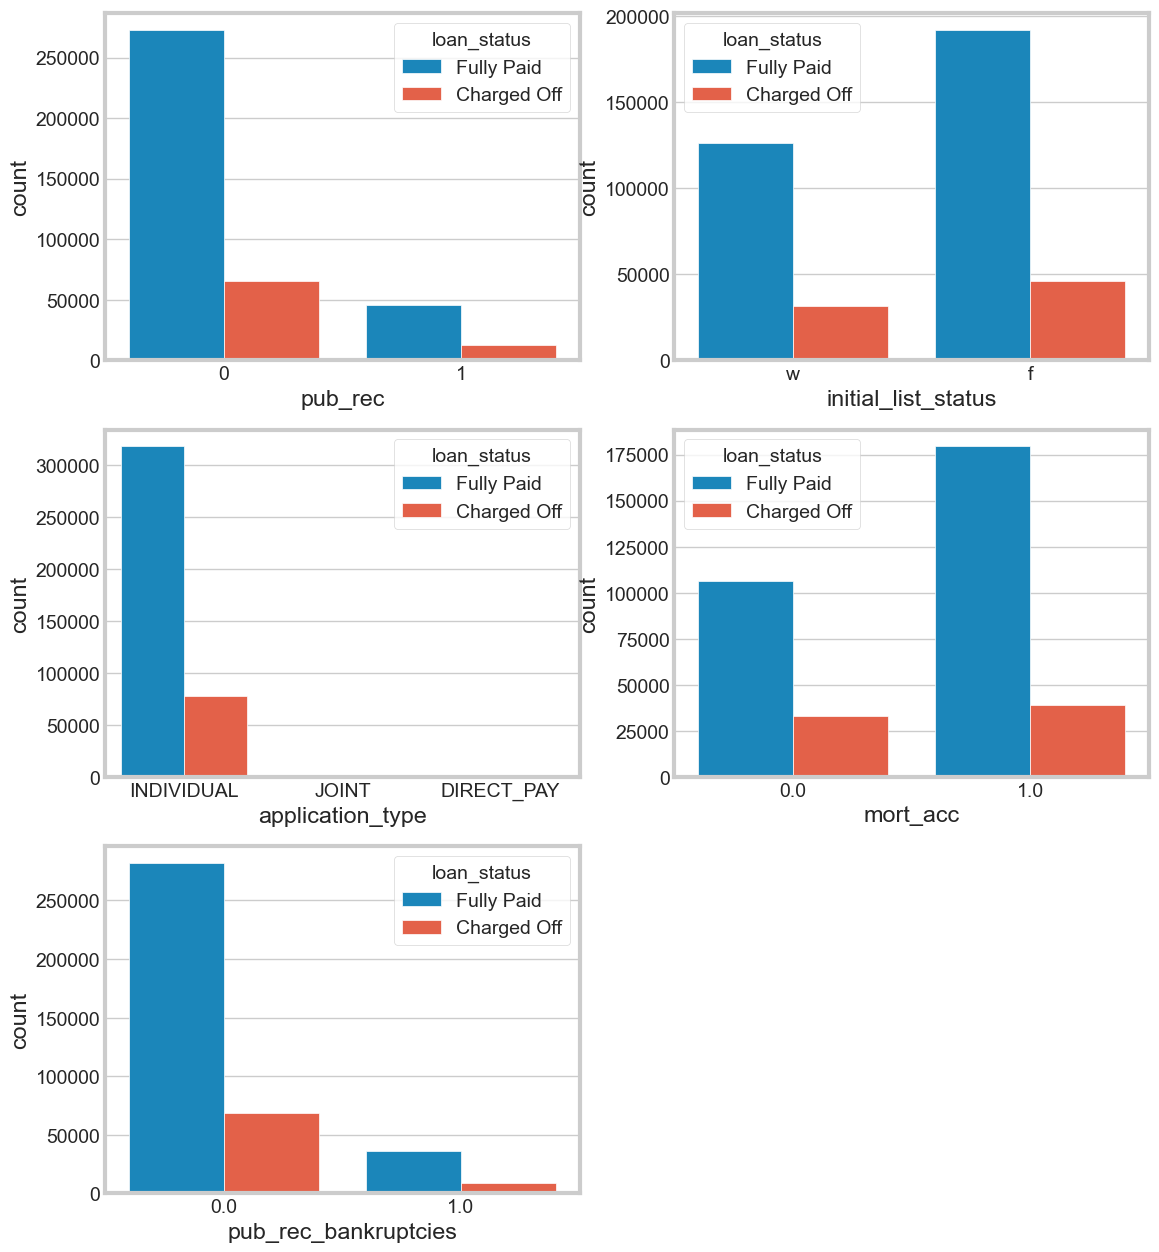

In [34]:
# Cada gráfico de conteo muestra la cantidad de cada valor único en una columna específica ('pub_rec', 'initial_list_status', 'application_type', 'mort_acc', 'pub_rec_bankruptcies') en el DataFrame 'data', dividido por 'loan_status'.

plt.figure(figsize=(12, 30))

plt.subplot(6, 2, 1)
sns.countplot(x='pub_rec', data=data, hue='loan_status')

plt.subplot(6, 2, 2)
sns.countplot(x='initial_list_status', data=data, hue='loan_status')

plt.subplot(6, 2, 3)
sns.countplot(x='application_type', data=data, hue='loan_status')

plt.subplot(6, 2, 4)
sns.countplot(x='mort_acc', data=data, hue='loan_status')

plt.subplot(6, 2, 5)
sns.countplot(x='pub_rec_bankruptcies', data=data, hue='loan_status')

Podemos decir ahora que hay dos tipos de características, características vinculadas al solicitante y características asociadas a las características del préstamo.
    

Aunque algunos aspectos del contenido pueden exceder mis conocimientos actuales, encuentro sumamente interesante la sección dedicada al machine learning clásico en el notebook original. En ella se abordan diversos modelos y técnicas de preprocesamiento de datos. Recomiendo encarecidamente revisar dicho material.